In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
class clustering_pipeline:
    def __init__(self, vectorizer, n_components, reducer):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        
    def fit(self, text):
        self.vectorizer.fit(text)
        self.vector_data = self.vectorizer.fit_transform(text)
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.texts = text

    def tsne(self, n_components, perplexity):
        tsne = TSNE(n_components = n_components, perplexity = perplexity)
        plt.figure(dpi=300)
        vector_tsne = tsne.fit_transform(self.topic_data)
        sns.scatterplot(vector_tsne[:, 0], vector_tsne[:, 1],hue=self.labels_, alpha=0.5, size = 0.5, 
                        palette='rainbow', legend='full')
        plt.title(f'tSNE on topic space using {self.cluster_method}');
        plt.figure(dpi=300)
        plt.hist(self.labels_, bins=self.n_clusters);
        
    def kmeans(self, n_clusters):
        self.km = KMeans(n_clusters=n_clusters)
        self.labels_ = self.km.fit_predict(self.vector_data)
        self.cluster_method='kmeans'
        self.n_clusters=n_clusters
        
    def db(self, eps, min_samples):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(self.x)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        self.labels_ = db.labels_
        self.cluster_method='db'
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        self.n_clusters=n_clusters

    def spectral(self, article, num_to_return, n_clusters):
        sc = SpectralClustering(n_clusters=n_clusters)
        self.labels_ = sc.fit_predict(self.x)
        self.cluster_method='spectral'
        self.n_clusters=n_clusters
        
    def meanshift(self, quantile, n_samples):
        bandwidth = estimate_bandwidth(self.x, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(self.x)
        self.labels_ = ms.labels_
        self.cluster_method = 'meanshift'
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(self.labels_)
        self.n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        result_texts = [self.texts[i] for i in results[1][0]]
        
        return result_texts

In [3]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

def find_cluster_closest_cosine_verses(cluster):
    overall_clusters=[]
    for number in set(cluster.labels_):
        cluster_center = cluster.km.cluster_centers_[number]
        distances=[]
    for index, vector in enumerate(cluster.topic_data):
        dist = cosine_similarity(cluster_center,vector)
        distances.append((dist, index))
    distances.sort()
    indices=[x[1] for x in distances[-4:]]
    print(distances[-4:])
    for i in indices:
        print(df.review.iloc[i])

In [4]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(df.ReviewText)
tfidf_data = tfidf_vectorizer.fit_transform(df.ReviewText)

In [6]:
n_comp = 40
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

# lsa_tfidf

In [7]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

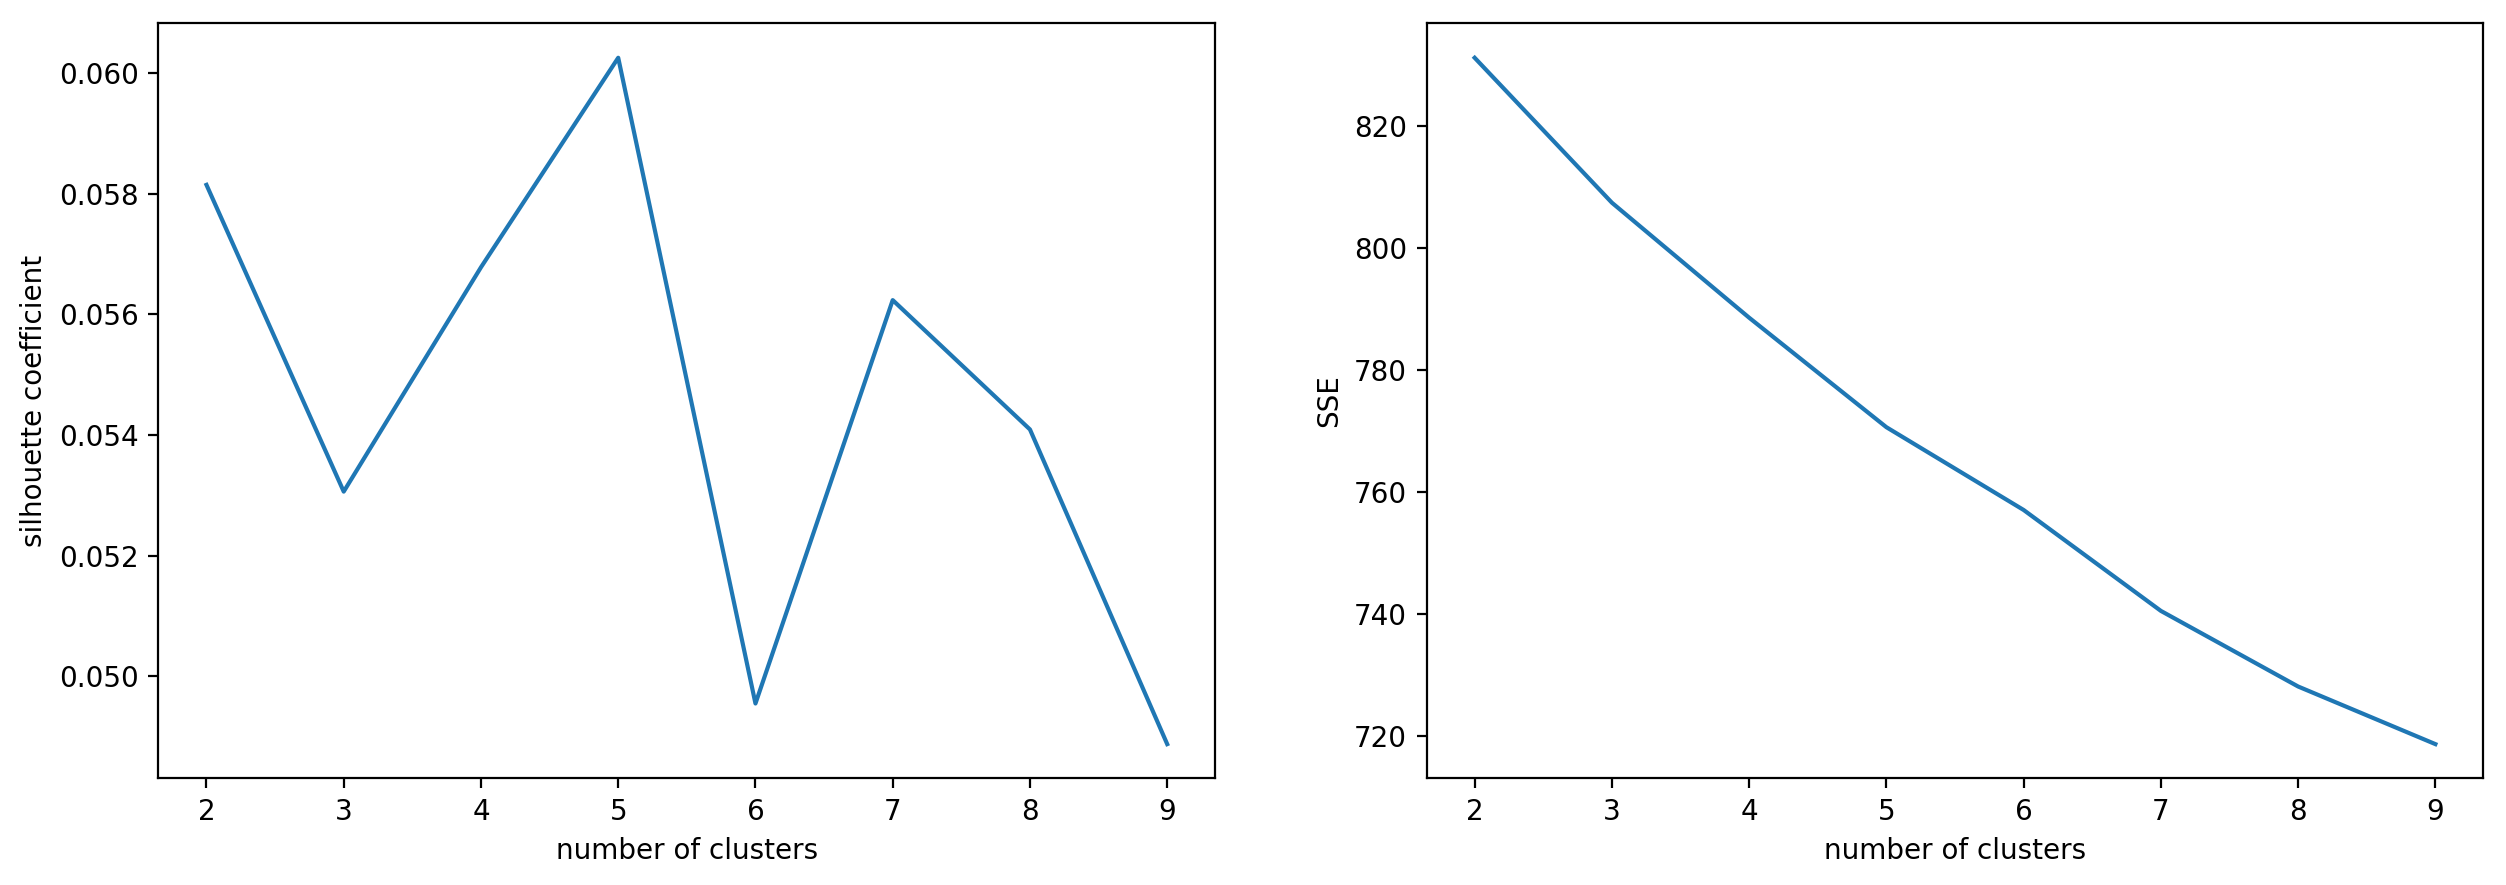

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [9]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 831.186701
# clusters:  3   Inertia: 807.410944
# clusters:  4   Inertia: 790.013147
# clusters:  5   Inertia: 771.772592
# clusters:  6   Inertia: 754.895446
# clusters:  7   Inertia: 740.310167
# clusters:  8   Inertia: 728.658188
# clusters:  9   Inertia: 718.081691
# clusters: 10   Inertia: 706.327120
# clusters: 11   Inertia: 700.125766
# clusters: 12   Inertia: 692.054117
# clusters: 13   Inertia: 678.223958
# clusters: 14   Inertia: 673.363549
# clusters: 15   Inertia: 665.795752
# clusters: 16   Inertia: 655.758460
# clusters: 17   Inertia: 652.819364
# clusters: 18   Inertia: 643.784008
# clusters: 19   Inertia: 638.439911
# clusters: 20   Inertia: 633.104290
# clusters: 21   Inertia: 628.285825
# clusters: 22   Inertia: 625.136822
# clusters: 23   Inertia: 623.091639
# clusters: 24   Inertia: 614.632629


(200, 500)

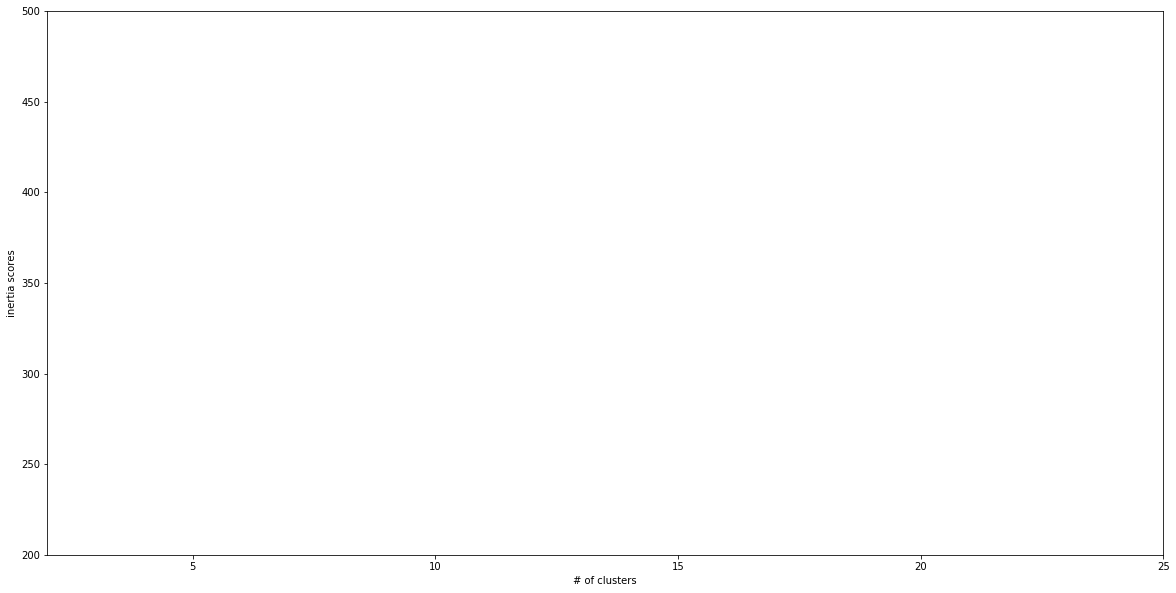

In [10]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((200,500))

# lsa_cv

In [11]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [ ]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((200,500))

# nmf_tfidf

In [ ]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [ ]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((200,500))

# nmf_cv

In [ ]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [ ]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((200,500))